In [1]:
# ===============================================================================================================#
# Copyright 2022 Infosys Ltd.                                                                                    #
# Use of this source code is governed by Apache License Version 2.0 that can be found in the LICENSE file or at  #
# http://www.apache.org/licenses/                                                                                #
# ===============================================================================================================#

## 1. Preparation

In [2]:
import json
import time
from libraries._internal_utils.demo_helper import DemoHelper
import pandas as pd
from IPython.display import Image

#### <span style='color:blue'>Add Tesseract to PATH environment variable</span>

In [3]:
# Add Tesseract to environment path if not set
import os

if (not len([x for x in os.environ['PATH'].split(';') if x.lower().find('tesseract') !=-1 ])):
    TESSERACT_HOME = os.environ['TESSERACT_HOME']
    os.environ['PATH']+=f";{TESSERACT_HOME}"
    print(f"Added tesseract path '{TESSERACT_HOME}' to environment path")

#### <span style='color:blue'>Enter image paths</span>

In [4]:
IMAGE_PATH='./data/sample_01.jpg_noline.png'
TEMP_FOLDER_PATH = './data/temp'

#### Visualize

In [5]:
IMAGE_PATHS=[IMAGE_PATH]
tab_widget = DemoHelper.create_tab_toolbar(IMAGE_PATHS)
display(tab_widget)
for idx, image_path in enumerate(IMAGE_PATHS):
    with tab_widget.children[idx]:
        display(Image(filename=image_path, width=1000, height=50)) 

## 2. Initialization

#### <span style='color:blue'>Create new instance</span>

In [6]:
import logging
import os
import infy_table_extractor as ite

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    
create_dir(TEMP_FOLDER_PATH)
create_dir('./logs')
    
logging.basicConfig(level=logging.CRITICAL, format='%(asctime)s.%(msecs)03d %(levelname)s'
                                ' ainauto-tabula - %(module)s - %(funcName)s: %(message)s')
logger = logging.getLogger()

# Providers
tesseract_provider = ite.borderless_table_extractor.providers.TesseractDataServiceProvider(
    None,logger=logger,log_level=logging.CRITICAL)
# bless table extractor initialize
obj = ite.borderless_table_extractor.BorderlessTableExtractor(
    TEMP_FOLDER_PATH,
    token_rows_cols_provider=tesseract_provider,
    token_detection_provider=tesseract_provider,
    token_enhance_provider=tesseract_provider,
    pytesseract_path=None
)

#### <span style='color:blue'>Enter Within Bounding Box Coordinates</span>

In [7]:
# Format = [x,y,w,h]
my_within_bbox = [40, 200, 2000, 400]

#### Visualize

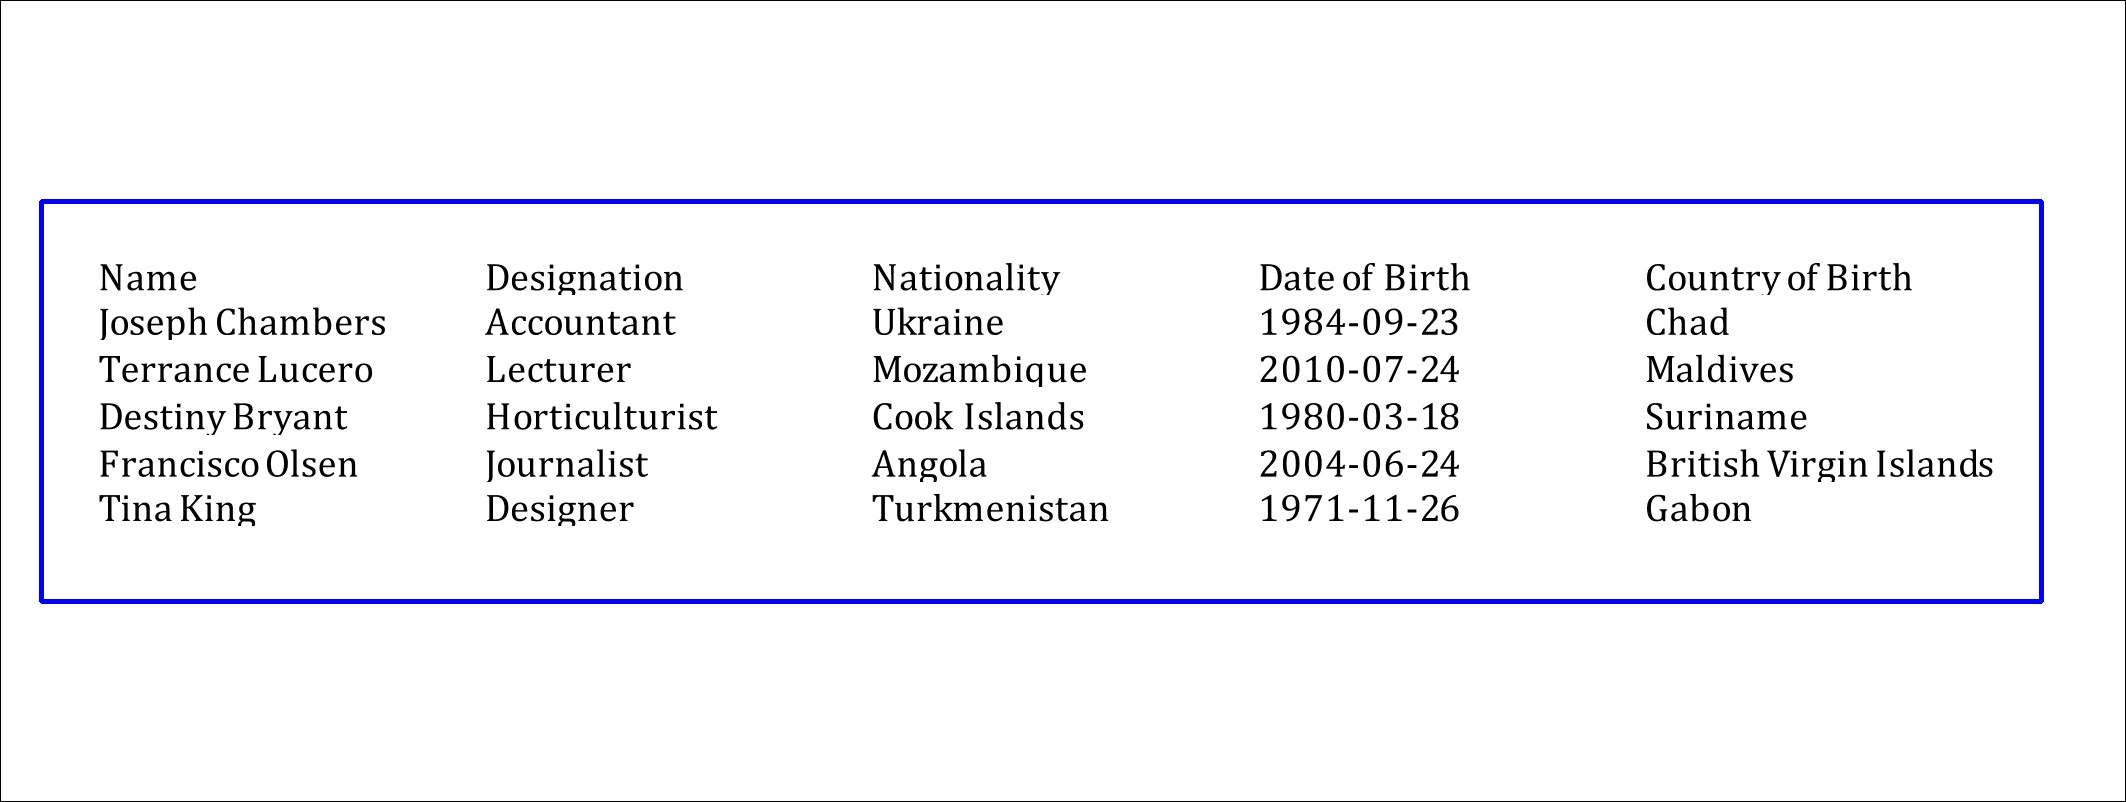

In [8]:
img = DemoHelper.read_image(IMAGE_PATH)
img = DemoHelper.draw_bboxes_on_image(img, [my_within_bbox], border_thickness=4,
                                         border_color = DemoHelper.Constants.COLOR_BLUE)
img = DemoHelper.reduce_image_based_on_context(img, [my_within_bbox])

DemoHelper.show_image(img)

## 3. API - extract_all_fields()

### 3.1 Example - To extract all cells using `is_virtual_table_mode` as `True`.
Using OCR word bbox and Image Pixel gap, virtually finding the horizontal and vertical lines and extracting cell values.

In [9]:
config_param_dict={
    "is_virtual_table_mode": True
}
start_time = time.time()
result_1 = obj.extract_all_fields(
    image_file_path=IMAGE_PATH,
    within_bbox=my_within_bbox, 
    config_param_dict=config_param_dict)
print("--- %s sec(s) ---" % round((time.time() - start_time),2))

--- 11.57 sec(s) ---


#### Output

In [10]:
# print(json.dumps(result_1, indent=4))
df = pd.json_normalize(result_1['fields'][0]['table_value'])
# Postprocessing to remove newline chars
df.columns = df.columns.str.replace(r'\n','', regex=True)
df.columns = df.columns.str.replace('&lt;br&gt;', '', regex=True)
df = df.replace(r'\n','', regex=True)

print('No. of records found =', len(df))
df.index = df.index + 1
df

No. of records found = 5


,Name,Designation,Nationality,Date of Birth,Country of Birth
1,Joseph Chambers,Accountant,Ukraine,1984-09-23,Chad
2,Terrance Lucero,Lecturer,Mozambique,2010-07-24,Maldives
3,Destiny Bryant,Horticulturist,Cook Islands,1980-03-18,Suriname
4,Francisco Olsen,Journalist,Angola,2004-06-24,British Virgin Islands
5,Tina King,Designer,Turkmenistan,1971-11-26,Gabon


### 3.2 Example - To extract all cells using `is_virtual_table_mode` as `False`
Using OCR bbox, finding the Rows and columns

In [11]:
config_param_dict={
    "is_virtual_table_mode": False
}
start_time = time.time()
result_2 = obj.extract_all_fields(
    image_file_path=IMAGE_PATH,
    within_bbox=my_within_bbox, 
    config_param_dict=config_param_dict)
print("--- %s sec(s) ---" % round((time.time() - start_time),2))

--- 13.81 sec(s) ---


#### Output

In [12]:
# print(json.dumps(result_2, indent=4))
df = pd.json_normalize(result_2['fields'][0]['table_value'])
# Postprocessing to remove newline chars
df.columns = df.columns.str.replace(r'\n','', regex=True)
df = df.replace(r'\n','', regex=True)

print('No. of records found =', len(df))
df.index = df.index + 1
df

No. of records found = 4


,Name,Designation,Nationality,Date of Birth,Country of Birth
1,Joseph Chambers,Accountant,Ukraine,1984-09-23,Chad
2,Terrance Lucero,Lecturer,Mozambique,2010-07-24,Maldives
3,Destiny Bryant,Horticulturist,Cook Islands,1980-03-18,Suriname
4,Francisco Olsen,Journalist,Angola,2004-06-24,British Virgin Islands


### 3.3 Example - To extract custom cells

In [13]:
config_param_dict = {
    "is_virtual_table_mode": True,
    "custom_cells": [
        {
            "rows": ["2:4"],
            "columns":[1]
        },
        {
            "rows": ["5"],
            "columns":[2]
        }
    ]
}

start_time = time.time()
result_3 = obj.extract_all_fields(image_file_path=IMAGE_PATH, 
                                  within_bbox = my_within_bbox,
                                  config_param_dict =config_param_dict)
print("--- %s sec(s) ---" % round((time.time() - start_time),2))

--- 12.61 sec(s) ---


#### Output

In [14]:
# print(json.dumps(result_3, indent=4))
df = pd.json_normalize(result_3['fields'][0]['table_value'])
# Postprocessing to remove newline chars
df.columns = df.columns.str.replace(r'\n','', regex=True)
df = df.replace(r'\n','', regex=True)

print('No. of records found =', len(df))
df.index = df.index + 1
df

No. of records found = 3


,Designation,Nationality
1,Lecturer,((Not Extracted))
2,Horticulturist,((Not Extracted))
3,((Not Extracted)),Turkmenistan
